In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import warnings
warnings.filterwarnings(action='ignore')
import lightgbm as lgb
from sklearn.metrics import *
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE

In [ ]:
train_err = pd.read_csv('/content/drive/MyDrive/데이콘/data/train_err_data.csv')
train_problem = pd.read_csv('/content/drive/MyDrive/데이콘/data/train_problem_data.csv')
test_err = pd.read_csv('/content/drive/MyDrive/데이콘/data/test_err_data.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/데이콘/data/sample_submission.csv')

In [ ]:
problem = np.zeros(15000)
problem[train_problem.user_id.unique()-10000] = 1 
problem.shape

(15000,)

In [ ]:
id_error = train_err[['user_id','errtype']].values
error = np.zeros((15000,42))

for person_idx, err in tqdm(id_error):
  error[person_idx-10000,err-1]+=1
error.shape

100%|██████████| 16554663/16554663 [00:39<00:00, 414669.58it/s]


(15000, 42)

In [ ]:
problem_df = pd.DataFrame(problem)
problem_df.rename({0:'problem'},axis=1,inplace=True)
problem_df['problem'].value_counts()

0.0    10000
1.0     5000
Name: problem, dtype: int64

In [ ]:
train_x = error
train_y = problem
print(train_x.shape)
print(train_y.shape)

(15000, 42)
(15000,)


In [ ]:
smote = SMOTE(random_state=0)
x_train_over, y_train_over = smote.fit_sample(train_x,train_y)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트:',x_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포:\n',pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트: (20000, 42) (20000,)
SMOTE 적용 후 레이블 값 분포:
 1.0    10000
0.0    10000
dtype: int64


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[666]	valid_0's auc: 0.919664	valid_0's pr_auc: 0.929595


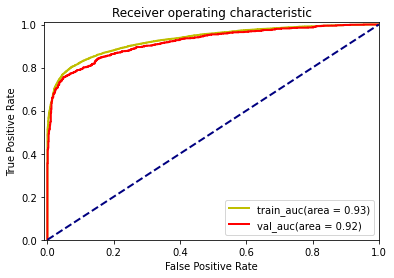

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[1200]	valid_0's auc: 0.897674	valid_0's pr_auc: 0.916392


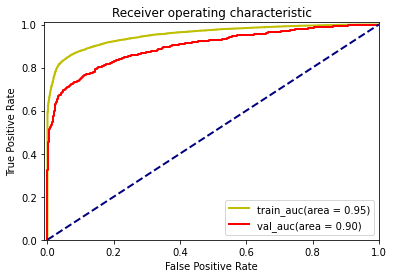

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[1038]	valid_0's auc: 0.905575	valid_0's pr_auc: 0.919665


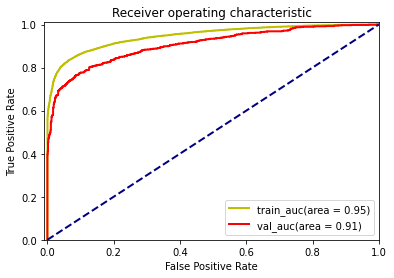

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[1184]	valid_0's auc: 0.920742	valid_0's pr_auc: 0.928948


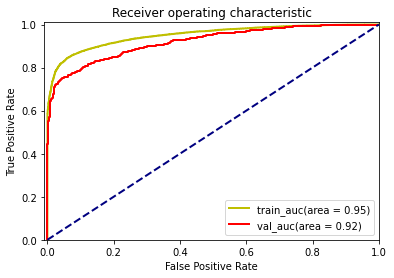

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[586]	valid_0's auc: 0.915051	valid_0's pr_auc: 0.91889


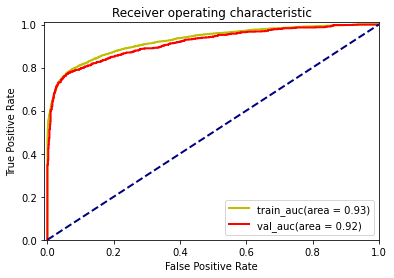

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[1200]	valid_0's auc: 0.908693	valid_0's pr_auc: 0.918841


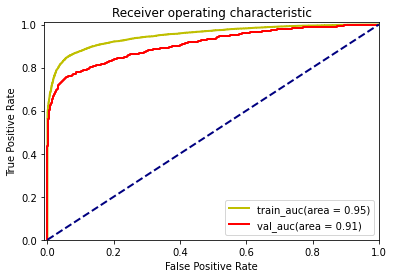

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[1189]	valid_0's auc: 0.913186	valid_0's pr_auc: 0.917237


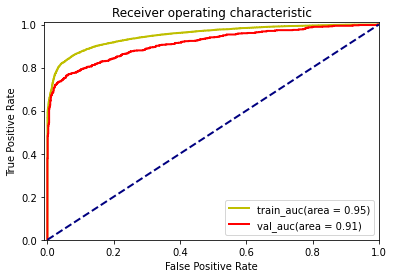

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[1165]	valid_0's auc: 0.918026	valid_0's pr_auc: 0.921532


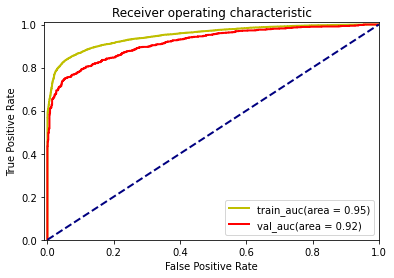

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[1192]	valid_0's auc: 0.913762	valid_0's pr_auc: 0.923202


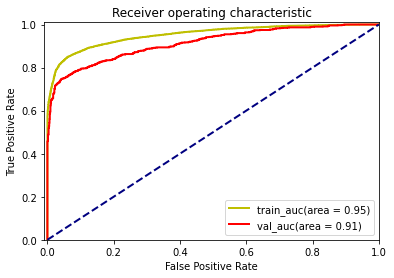

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[658]	valid_0's auc: 0.871955	valid_0's pr_auc: 0.986868


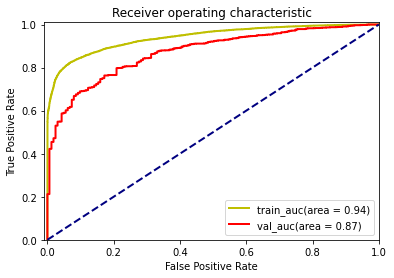

In [ ]:
# validation auc score를 확인하기 위해 정의
def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True
#-------------------------------------------------------------------------------------
models     = []
recalls    = []
precisions = []
auc_scores   = []
accuracies   = []
f1_scores = []

threshold = 0.5
# 파라미터 설정
params =      {
                'boosting_type' : 'dart',
                'objective'     : 'binary',
                'metric'        : 'auc',
                'learning_rate' : '0.02',
                'seed': 1015
                }

#-------------------------------------------------------------------------------------
# 5 Kfold cross validation
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
for train_idx, val_idx in k_fold.split(x_train_over):

    # split train, validation set
    X = x_train_over[train_idx]
    y = y_train_over[train_idx]
    valid_x = x_train_over[val_idx]
    valid_y = y_train_over[val_idx]

    d_train= lgb.Dataset(X, y)
    d_val  = lgb.Dataset(valid_x, valid_y)
    
    #run traning
    model = lgb.train(
                        params,
                        train_set       = d_train,
                        num_boost_round = 1200,
                        valid_sets      = d_val,
                        feval           = f_pr_auc,
                        verbose_eval    = 'False',
                        # early_stopping_rounds = 200
                       )
    
    y_pred_train = model.predict(X).ravel()
    fpr1, tpr1, thresholds = roc_curve(y,y_pred_train)

    y_pred = model.predict(valid_x).ravel()
    fpr, tpr, thresholds = roc_curve(valid_y, y_pred)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr1, tpr1, color='y',
             lw=2, label='train_auc(area = %0.2f)' % auc(fpr1, tpr1))
    plt.plot(fpr, tpr, color='r',
            lw=2, label='val_auc(area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # cal valid prediction
    valid_prob = model.predict(valid_x)
    valid_pred = np.where(valid_prob > threshold, 1, 0)
    
    # cal scores
    recall    = recall_score(    valid_y, valid_pred)
    precision = precision_score( valid_y, valid_pred)
    auc_score = roc_auc_score(   valid_y, valid_prob)
    accuracy  = accuracy_score(valid_y,valid_pred)
    f1__score = f1_score(valid_y,valid_pred)

    # append scores
    models.append(model)
    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    auc_scores.append(auc_score)
    f1_scores.append(f1__score)

    print('==========================================================')

In [ ]:
print(np.mean(auc_scores))
print(np.mean(accuracies))
print(np.mean(precision))
print(np.mean(recall))
print(np.mean(f1_scores))

0.9084327907729778
0.8049
0.9852941176470589
0.6929776810016332
0.8073942090593155


In [ ]:
test_user_id_max = 44998
test_user_id_min = 30000
test_user_number = 14999

In [ ]:
id_error = test_err[['user_id','errtype']].values
test_x = np.zeros((test_user_number,42))
for person_idx, err in tqdm(id_error):
    # person_idx - test_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    test_x[person_idx - test_user_id_min,err - 1] += 1
test_x = test_x.reshape(test_x.shape[0],-1)
print(test_x.shape)

100%|██████████| 16532648/16532648 [00:40<00:00, 405980.53it/s]

(14999, 42)


In [ ]:
pred_y_list = []
for model in models:
    pred_y = model.predict(test_x)
    pred_y_list.append(pred_y.reshape(-1,1))
    
pred_ensemble = np.mean(pred_y_list, axis = 0)

In [ ]:
# pred = np.where(pred_ensemble>0.5,1,0)
# pred

In [ ]:
sample_submission['problem'] = pred_ensemble
sample_submission[:10]

,user_id,problem
0,30000,0.966676
1,30001,0.263208
2,30002,0.275944
3,30003,0.861284
4,30004,0.762197
5,30005,0.421317
6,30006,0.108298
7,30007,0.047985
8,30008,0.777615
9,30009,0.268688


In [ ]:
sample_submission.to_csv('/content/drive/MyDrive/데이콘/submission/lgb_smote_kfold10_submission.csv')